In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

path_to_dir = "/home/kelvinfung/Documents/bounce-digits/"

import sys
sys.path.append(path_to_dir)
from models import *
from data.data_classes import *

## Load data

In [2]:
num_context_frames = 5
num_target_frames = 5
batch_size = 50

mnist_module = MovingMNISTDataModule(batch_size, num_context_frames, num_target_frames) 
mnist_module.setup()

In [3]:
train_dataloader = mnist_module.train_dataloader()
for train_x_batch, train_y_batch in train_dataloader:
    break

train_x_batch.shape  # bs x C x F x H x W

torch.Size([50, 1, 5, 64, 64])

In [6]:
torch.stack((train_x_batch, train_y_batch)).shape

torch.Size([2, 50, 1, 5, 64, 64])

(array([19210.,    75.,    55.,    60.,    65.,    80.,    85.,    50.,
           75.,   725.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

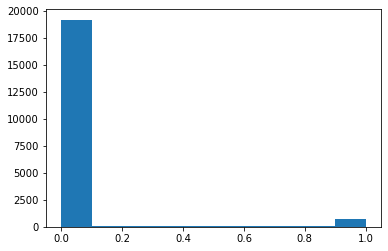

In [4]:
plt.hist(train_x_batch[0].flatten())

## Test metrics

In [5]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

In [6]:
class PSNR(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, pred_frames, target_frames):
        N, C, F, H, W = pred_frames.shape
        out = np.zeros((N, F))
        for vid_idx in range(N):
            for frame_idx in range(F):
                psnr = peak_signal_noise_ratio(
                    pred_frames[vid_idx, :, frame_idx].numpy(),
                    target_frames[vid_idx, :, frame_idx].numpy(),
                    data_range=1.0
                )
                out[vid_idx, frame_idx] = psnr
        return out.mean()

class SSIM(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, pred_frames, target_frames):
        N, C, F, H, W = pred_frames.shape
        out = np.zeros((N, F))
        for vid_idx in range(N):
            for frame_idx in range(F):
                ssim = structural_similarity(
                    pred_frames[vid_idx, :, frame_idx].numpy().squeeze(),
                    target_frames[vid_idx, :, frame_idx].numpy().squeeze(),
                    data_range=1.0
                )
                out[vid_idx, frame_idx] = ssim
        return out.mean()

In [7]:
vid1, vid2 = train_x_batch, train_y_batch

In [8]:
psnr = PSNR()
ssim = SSIM()
print(f'psnr: {psnr(vid1, vid2)}')
print(f'ssim: {ssim(vid1, vid2)}')

psnr: 11.14639784144636
ssim: 0.6273911063010392


In [9]:
print(f'psnr: {psnr(vid1, vid1)}')
print(f'ssim: {ssim(vid1, vid1)}')

psnr: inf
ssim: 1.0


/home/kelvinfung/miniconda3/envs/pytorch/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


## Test plotting function

In [43]:
def make_grid(ctx, tgt, pred, epoch, cmap='gray'):
    num_ctx_frames= ctx.shape[1]
    num_tgt_frames = tgt.shape[1]

    def show_frames(frames, ax, row_label=None):
        for i, frame in enumerate(frames):
            if cmap is not None:
                ax[i].imshow(frame, cmap)
            else:
                ax[i].imshow(frame)
            ax[i].set_xticks([])
            ax[i].set_yticks([])

        if row_label is not None:
            ax[0].set_ylabel(row_label)

    ctx_frames = ctx.squeeze().cpu().numpy()
    tgt_frames = tgt.squeeze().cpu().numpy()
    pred_frames = pred.squeeze().cpu().numpy()

    fig, ax = plt.subplots(3, max(num_ctx_frames, num_tgt_frames),
                       figsize = (9, 5))
    fig.suptitle(f"EPOCH {epoch}", y=0.93)
    show_frames(ctx_frames, ax[0], "Context")
    show_frames(tgt_frames, ax[1], "Target")
    show_frames(pred_frames, ax[2], "Prediction")


    return fig

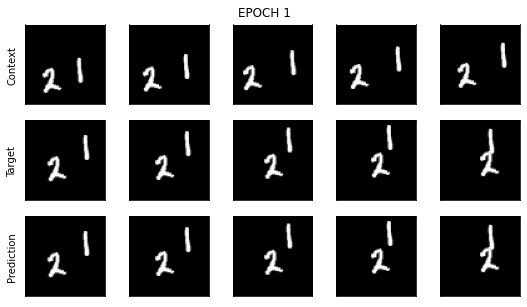

In [44]:
fig = make_grid(train_x_batch[5], train_y_batch[5], train_y_batch[5], 1)

In [32]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    shp = (nrows, ncols, 3)
    return np.frombuffer(buf, dtype=np.uint8).reshape(shp)

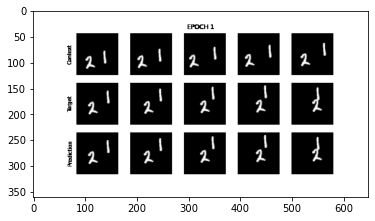

In [46]:
arr = fig2rgb_array(fig)
plt.imshow(arr)

In [49]:
arr.dtype

dtype('uint8')

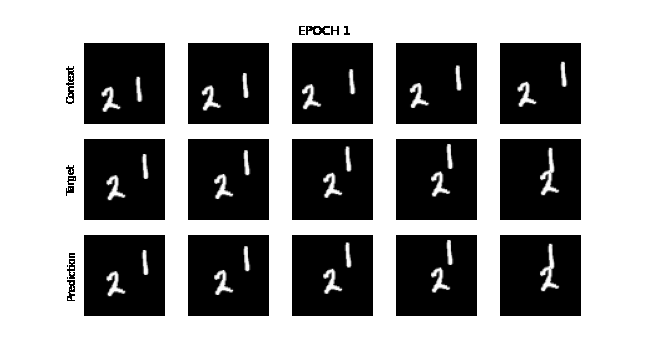

In [48]:
from PIL import Image
Image.fromarray(arr)

(array([279570.,   1776.,   1353.,   1149.,   1395.,    963.,   1122.,
          1149.,   2034., 409329.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

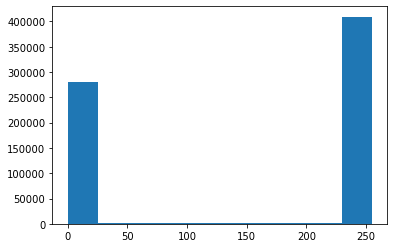

In [52]:
plt.hist(arr.flatten())